# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

<font color='blue'>Added the following code to make the MNIST results reproducible (font: https://deeplizard.com/learn/video/HcW0DeWRggs) </font>

In [1]:
import numpy as np
import tensorflow
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(42)
rn.seed(1234)
tensorflow.random.set_seed(1)

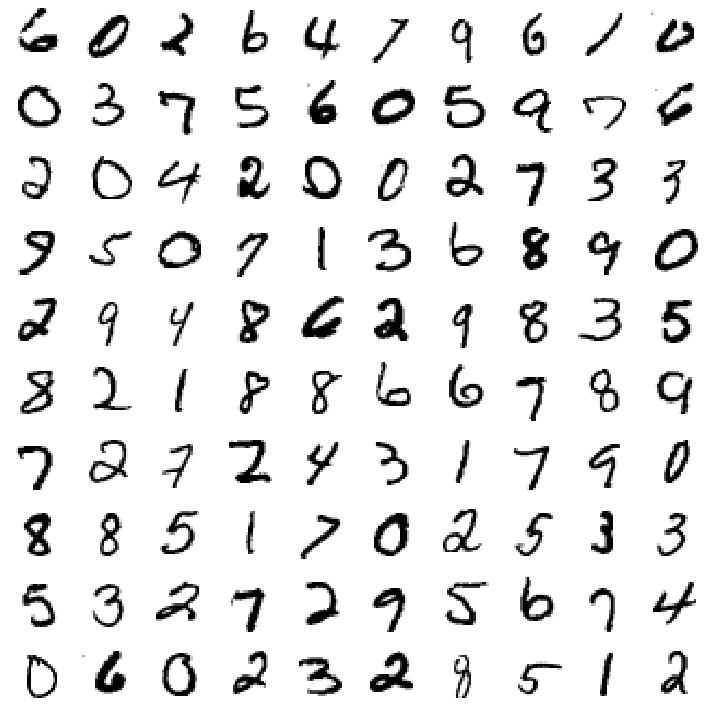

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train_MNIST, y_train_MNIST), (x_test_MNIST, y_test_MNIST) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train_MNIST = (x_train_MNIST / 255.0).astype(np.float32)
x_test_MNIST = (x_test_MNIST / 255.0).astype(np.float32)

# convert the data to channel-last
x_train_MNIST = np.expand_dims(x_train_MNIST, axis=-1)
x_test_MNIST = np.expand_dims(x_test_MNIST, axis=-1)

# convert the labels to one-hot encoded
y_train_MNIST = to_categorical(y_train_MNIST, num_classes=10)
y_test_MNIST = to_categorical(y_test_MNIST, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train_MNIST[np.random.randint(0, x_train_MNIST.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)              

Compile and train the network (note that this could take a while).

In [8]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train_MNIST, y_train_MNIST,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test_MNIST, y_test_MNIST))

score = model.evaluate(x_test_MNIST, y_test_MNIST, verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 125s 2ms/step - loss: 0.2446 - accuracy: 0.9262 - val_loss: 0.0559 - val_accuracy: 0.9816
Epoch 2/12
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0885 - accuracy: 0.9738 - val_loss: 0.0368 - val_accuracy: 0.9870
Epoch 3/12
60000/60000 [==============================] - 117s 2ms/step - loss: 0.0662 - accuracy: 0.9803 - val_loss: 0.0391 - val_accuracy: 0.9878
Epoch 4/12
60000/60000 [==============================] - 133s 2ms/step - loss: 0.0541 - accuracy: 0.9832 - val_loss: 0.0329 - val_accuracy: 0.9896
Epoch 5/12
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0462 - accuracy: 0.9854 - val_loss: 0.0268 - val_accuracy: 0.9909
Epoch 6/12
60000/60000 [==============================] - 133s 2ms/step - loss: 0.0419 - accuracy: 0.9867 - val_loss: 0.0290 - val_accuracy: 0.9912
Epoch 7/12
60000/60000 [==============================] - 120s

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [9]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02945587009811368
Test accuracy: 0.9908999800682068


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


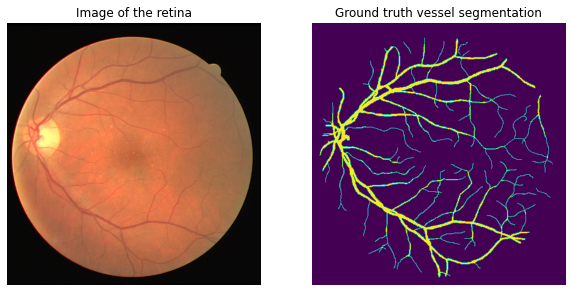

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import sys
sys.path.append('./code')
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = './data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valIdation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


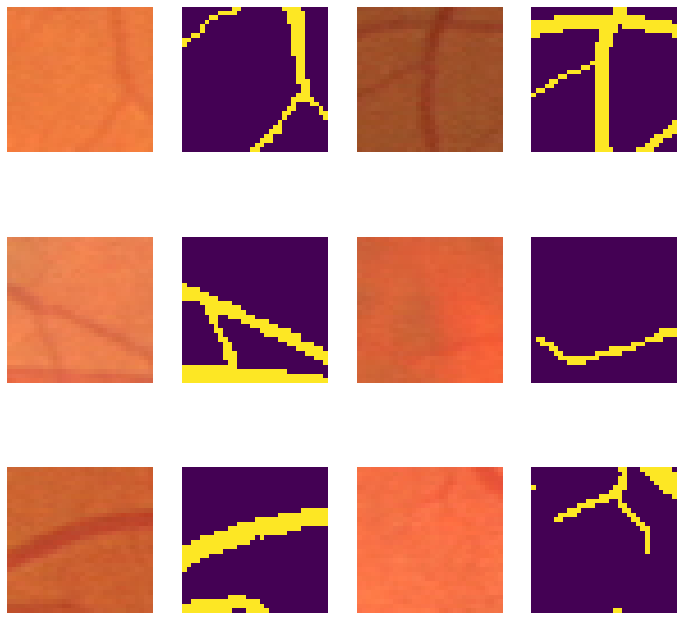

In [2]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [3]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [13]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/250
 - 115s - loss: 0.4832 - accuracy: 0.8413 - val_loss: 0.3908 - val_accuracy: 0.9211
Epoch 2/250
 - 98s - loss: 0.2909 - accuracy: 0.9501 - val_loss: 0.2748 - val_accuracy: 0.9211
Epoch 3/250
 - 103s - loss: 0.2268 - accuracy: 0.9556 - val_loss: 0.3871 - val_accuracy: 0.8073
Epoch 4/250
 - 102s - loss: 0.2098 - accuracy: 0.9520 - val_loss: 4.3594 - val_accuracy: 0.5399
Epoch 5/250
 - 105s - loss: 0.1672 - accuracy: 0.9569 - val_loss: 0.2834 - val_accuracy: 0.9225
Epoch 6/250
 - 107s - loss: 0.1728 - accuracy: 0.9545 - val_loss: 0.2928 - val_accuracy: 0.9211
Epoch 7/250
 - 98s - loss: 0.1390 - accuracy: 0.9600 - val_loss: 0.3690 - val_accuracy: 0.9212
Epoch 8/250
 - 92s - loss: 0.1271 - accuracy: 0.9613 - val_loss: 0.2897 - val_accuracy: 0.9226
Epoch 9/250
 - 100s - loss: 0.1268 - accuracy: 0.9601 - val_loss: 0.1898 - val_accuracy: 0.9375
Epoch 10/250
 - 117s - loss: 0.1131 - accuracy: 0.9623 - val_loss: 0.2114 - val_accuracy: 0.9323
Epoch 11

### Visualizing the segmentation results

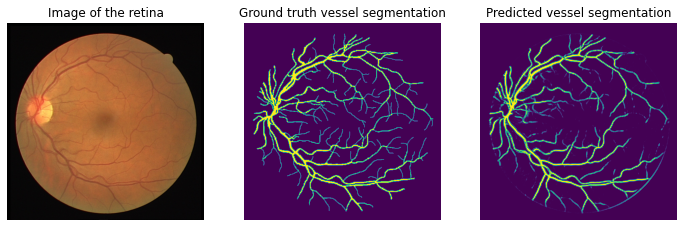

In [14]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

**Question:** What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?

**Answer:** For a convolutional layer, the number of parameters depends of the size of the kernel (width w, height h), the number of filters from the previous layer m and the number of filters from this layer n. So the number of parameters for a convolutional layer equals $(w*h*m+1)*n$. For the first convolutional layer, the kernel' size is $3*3$, the number of filter from the previous layer which is the input image is 1 and the number of filter from this layer is 32 which gives $(3*3*1+1)*32=320$. Same result as stated above

It already represents a decent number of parameters. However, for a fullly-connected layer there is a weight for each current layer's neuron - previous layer's neuron connection and also a weight for the bias of each neuron of the current layer. The number of parameters for a fully-connected layer with c neurons and a previous layer with d neurons then equals to $c*d+1*c$. For the first fully-connected layer of the model used above with 128 neurons and a previous layer with output size of $9216*1$ which makes it corresponds to 9216 neurons, it gives a number of parameters for the FC layer of $9216*128+128=1179,776$ aslo as stated above.

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

$I$ = Size (width) of input image; 
$O$ = Size (width) of output image; 
$K$ = Size (width) of kernels used in the Conv Layer;
$N$ = Number of kernels;
$C$ = Number of channels of the input image;
$S$ = Stride of the convolution operation. Default = (1,1);
$P$ = Padding. Default = "valid". Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution;
$W_c$ = Number of weights of the Conv Layer;
$B_c$ = Number of biases of the Conv Layer;
$P_c$ = Number of parameters of the Conv Layer.

**Number of Parameters of a Conv Layer:** In a CNN, each layer has two kinds of parameters, weights and biases. The total number of parameters is just the sum of all weights and biases.
\begin{align*}P_c &= W_c + B_c = (K^2 \times C \times N) + N = (K^2 \times C + 1)\times N \end{align*}

**Size of the Output Tensor (Image) of a Conv Layer:**
\begin{align*}O &= \frac{I - K + 2P}{S} + 1\end{align*}
In this exercise, $P$ is always equal to 0 and $S$ is always equal to 1 (for the convolution layers). Therefore, we can simply the formula:
\begin{align*}O &= I - K + 1\end{align*}

Font: https://learnopencv.com/number-of-parameters-and-tensor-sizes-in-convolutional-neural-network/ (accessed in 09/10/2021)

**Conv2D:**
- Input shape: batch_shape + (rows, cols, channels)
- Output shape: batch_shape + (new_rows, new_cols, filters)

**First 2D Convolution Layer:**
The input shape is (None, 28, 28, 1). This means that I = 28 and C = 1. The arguments in "Conv2D(32, (3, 3))" mean that we are learning a total of 32 filters (N = 32) and that the kernel size is (3, 3) (K = 3).

- $P_c = (3^2 \times 1 + 1) \times 32 = 320$
- $O = 28 - 3 + 1 = 26$
- Output shape = (None, 26, 26, 32)

**Second 2D Convolution Layer:** 
The input shape is (None, 26, 26, 32). This means that I = 26 and C = 32. The arguments in "Conv2D(64, (3, 3))" mean that N = 64 and that K = 3.

- $P_c = (3^2 \times 32 + 1) \times 64 = 18496$
- $O = 26 - 3 + 1 = 24$
- Output shape = (None, 24, 24, 64)

**MaxPooling 2D Layer:** 
The output shape for the pooling layer can be calculated using the same method as for the Convolution layer. The pool size is (2, 2), which means that K = 2. The input shape is (None, 24, 24, 64), meaning that I = 24. The stride is not specified, which means that it will default to pool_size (S = 2). 

- $O = (24 - 2 + 2 \times 0)/2 +1 = 12$
- Output shape = (None, 12, 12, 64)

**Third 2D Convolution Layer:**
The input shape is (None, 12, 12, 64). This means that I = 12 and C = 64. The number of parameters ($P_c$) must be equal to 1179776. As the Output Shape of the Dense Layer was (None, 128), N = 128.

- $P_c = (K^2 \times 64 + 1) \times 128 = 1179776 \Leftrightarrow (K^2 \times 64) = 9216 \Leftrightarrow K = 12$
- $O = 12 - 12 + 1 = 1$
- Output shape = (None, 1, 1, 128)

**Fourth 2D Convolution Layer:** 
The input shape is (None, 1, 1, 128). This means that I = 1 and C = 128. The number of parameters ($P_c$) must be equal to 1290. As the Output Shape of the Dense Layer was (None, 10), N = 10.

- $P_c = (K^2 \times 128 + 1) \times 10 = 1290 \Leftrightarrow (K^2 \times 128) = 128 \Leftrightarrow K = 1$
- $O = 1 - 1 + 1 = 1$
- Output shape = (None, 1, 1, 10)

In [30]:
from keras.models import Sequential
from keras.layers import Conv2D, Reshape, GlobalAveragePooling2D, Activation

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(128, (12,12), activation='relu'))
model2.add(Dropout(0.5))
model2.add(Conv2D(10, (1, 1), activation='softmax'))
model2.add(Flatten())
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 1, 1, 128)         1179776   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 1, 1, 10)         

In [31]:
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model2.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model2.fit(x_train_MNIST, y_train_MNIST,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test_MNIST, y_test_MNIST))

score2 = model2.evaluate(x_test_MNIST, y_test_MNIST, verbose=0)

print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 343s 6ms/step - loss: 0.2499 - accuracy: 0.9255 - val_loss: 0.0560 - val_accuracy: 0.9811
Epoch 2/12
60000/60000 [==============================] - 1575s 26ms/step - loss: 0.0888 - accuracy: 0.9726 - val_loss: 0.0401 - val_accuracy: 0.9870
Epoch 3/12
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0653 - accuracy: 0.9810 - val_loss: 0.0335 - val_accuracy: 0.9883
Epoch 4/12
60000/60000 [==============================] - 344s 6ms/step - loss: 0.0538 - accuracy: 0.9829 - val_loss: 0.0286 - val_accuracy: 0.9908
Epoch 5/12
60000/60000 [==============================] - 351s 6ms/step - loss: 0.0468 - accuracy: 0.9852 - val_loss: 0.0280 - val_accuracy: 0.9906
Epoch 6/12
60000/60000 [==============================] - 564s 9ms/step - loss: 0.0408 - accuracy: 0.9875 - val_loss: 0.0274 - val_accuracy: 0.9909
Epoch 7/12
60000/60000 [==============================] - 57

The test accuracy is approximately equal to 99.09% for the model with dense hidden layers, and approximatelly equal to 99.23% for the fully-convolutional MNIST model. This means that the test accuracy is 0.14% higher for the latter. Because of this negligible difference, we can say that both networks have the same behaviour (they represent the same model, only with a different implementation).

## U-Net architecture

**Question:** What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?

**Answer:** The role of the skip connections in the U-Net neural network architecture is to recover spatial information which was lost during downsampling. In the downsampling path of the U-Net the resolution of the images is reduced and therefore the localization ability of the network decreases. The skip connections solves this problem. With skip connections the features from the downsampling path are concatenated to the featuremaps from the upsampling path. In this way high level contextual information from the upsampling path can be combined with low level information from the downsampling path.     

It would be possible to train the exact same architecture with the skip connections omitted, but the model would make less good predictions. During downsampling, a lot of the localization accuracy will be lost and without the skip connections this informations cannot be retrieved. Thus we would end up with a U-Net neural network with a very low localization accuracy. 

## Data augmentation

**Question:** Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?

**Answer:** With data augmentation new, plausible data examples are created by transforming the existing examples. This increases both the amount of data and the diversity of the data. This makes the model better at generalizing. Thereby the variance of the model reduces and the model will overfit less on the training dataset. Data augmentation can be applied to the test samples. It is then called test time augmentation (TTA). The goal of this is to improve the prediction accuracy. Here we can make multiple augmentated versions of a test sample with plausible transformations, and make predictions for each sample. The final error for the initial test sample is then calculated by averaging the error of the original and the augmented versions of this sample.

Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

(1, 584, 565, 3)
(1, 584, 565, 1)
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/250
50/50 - 98s - loss: 0.5624 - accuracy: 0.7561 - val_loss: 0.4662 - val_accuracy: 0.9180
Epoch 2/250
50/50 - 95s - loss: 0.3193 - accuracy: 0.9379 - val_loss: 0.2661 - val_accuracy: 0.9180
Epoch 3/250
50/50 - 98s - loss: 0.2215 - accuracy: 0.9531 - val_loss: 0.2827 - val_accuracy: 0.9180
Epoch 4/250
50/50 - 98s - loss: 0.1750 - accuracy: 0.9556 - val_loss: 0.2952 - val_accuracy: 0.9180
Epoch 5/250
50/50 - 97s - loss: 0.1591 - accuracy: 0.9570 - val_loss: 0.2725 - val_accuracy: 0.9180
Epoch 6/250
50/50 - 85s - loss: 0.1448 - accuracy: 0.9575 - val_loss: 0.2702 - val_accuracy: 0.9180
Epoch 7/250
50/50 - 92s - loss: 0.1334 - accuracy: 0.9583 - val_loss: 0.2594 - val_accuracy: 0.9181
Epoch 8/250
50/50 - 97s - loss: 0.1352 - accuracy: 0.9566 - val_loss: 0.3251 - val_accuracy: 0.9180
Epoch 9/250
50/50 - 98s - loss: 0.1261 - accuracy: 0.9585 - val_loss: 0.3217 - val_accurac

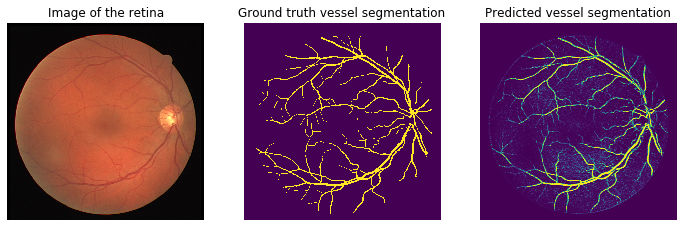

In [4]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import random

# randomise brightness in training images
brightness = [2 * random.random() for _ in range(len(train_images))] # random floats between 0 and 2
train_images_random_brightness = np.array([brightness[i]*train_images[i] for i in range(len(train_images))])

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images_random_brightness[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images_random_brightness)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])
print("Training finished")

# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

_At first sight it can be observed that the predicted vessel segmentation with random brightness has less details than the earlier one, but it looks a lot more like the ground truth. Apart from that, it can be observed that the loss is lower with random brightness, whereas the validation loss isn't, but both accuracies are slightly higher with random brightness._

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('./code')
import os
from unet_model import unet
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data, extract_patches, preprocessing, datagenerator, data_aug

# location of the DRIVE dataset
data_folder = './data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns
val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

aug_number = 10
train_images, train_segmentations, train_masks = data_aug(train_images, train_segmentations, train_masks, aug_number, -0.5, 0.5, True)

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(train_images, train_segmentations, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

Epoch 1/250
 - 99s - loss: 0.5265 - accuracy: 0.8150 - val_loss: 0.2946 - val_accuracy: 0.9211
Epoch 2/250
 - 95s - loss: 0.3241 - accuracy: 0.4179 - val_loss: 0.4571 - val_accuracy: 0.9211
Epoch 3/250
 - 109s - loss: 0.2484 - accuracy: 0.6433 - val_loss: 0.2764 - val_accuracy: 0.9211
Epoch 4/250
 - 107s - loss: 0.1933 - accuracy: 0.7305 - val_loss: 0.2708 - val_accuracy: 0.9211
Epoch 5/250
 - 102s - loss: 0.1646 - accuracy: 0.4339 - val_loss: 0.4527 - val_accuracy: 0.9212
Epoch 6/250
 - 95s - loss: 0.1453 - accuracy: 0.8852 - val_loss: 0.2672 - val_accuracy: 0.9214
Epoch 7/250
 - 91s - loss: 0.1406 - accuracy: 0.4916 - val_loss: 0.3123 - val_accuracy: 0.9213
Epoch 8/250
 - 91s - loss: 0.1323 - accuracy: 0.5844 - val_loss: 0.1946 - val_accuracy: 0.9306
Epoch 9/250
 - 91s - loss: 0.1167 - accuracy: 0.8062 - val_loss: 0.1978 - val_accuracy: 0.9361
Epoch 10/250
 - 91s - loss: 0.1208 - accuracy: 0.4258 - val_loss: 0.1663 - val_accuracy: 0.9481
Epoch 11/250
 - 95s - loss: 0.1173 - accuracy:

Epoch 86/250
 - 106s - loss: 0.0820 - accuracy: 0.7441 - val_loss: 0.0976 - val_accuracy: 0.9627
Epoch 87/250
 - 108s - loss: 0.0934 - accuracy: 0.4145 - val_loss: 0.0823 - val_accuracy: 0.9681
Epoch 88/250
 - 109s - loss: 0.0915 - accuracy: 0.8930 - val_loss: 0.0922 - val_accuracy: 0.9632


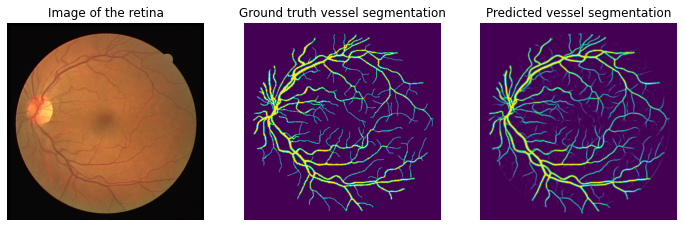

In [4]:
# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

From the picture above, it can be observed that the predicted vessel segmentation obtained using a model with brightness augmentation and b-spline geometric augmentation is very similar to the ground truth vessel segmentation, and it has even more details than the ground truth one. The val_accuracy obtained is considerable highter in comparison with the val_accuracies obtained both with the baseline and with the model that only performs brightness augmentation. Moreover, the val_loss obtained is considerable lower in comparison with the val_losses obtained both with the baseline and with the model that only performs brightness augmentation. However, it should be noted that in this case, we used all the training images, while in the previous models, only a single training image was used. Therefore, it would also be interesting to compare with a model perfoming only brightness augmentation, but implemented in a similar way as this one. 

Below, there's the implementation of such model, where the parameter "bspline" of the function data_aug is set to False, and the number of epochs is 20 (to reduce the computing time). With only 20 epochs, the val_accuracy is already higher than the val_accuracy in the other implementation. However, the maximum val_accuracy is not as high as the maximum val_accuracy in the first 20 epochs of the model performing b-spline augmentation. 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('./code')
import os
from unet_model import unet
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data, extract_patches, preprocessing, datagenerator, data_aug

# location of the DRIVE dataset
data_folder = './data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns
val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 20
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

aug_number = 10
train_images, train_segmentations, train_masks = data_aug(train_images, train_segmentations, train_masks, aug_number, -0.5, 0.5, False)

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(train_images, train_segmentations, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

Epoch 1/20
 - 117s - loss: 0.5462 - accuracy: 0.7750 - val_loss: 0.3662 - val_accuracy: 0.9211
Epoch 2/20
 - 123s - loss: 0.4963 - accuracy: 0.5787 - val_loss: 0.5233 - val_accuracy: 0.8396
Epoch 3/20
 - 117s - loss: 0.3688 - accuracy: 0.7669 - val_loss: 0.2861 - val_accuracy: 0.9211
Epoch 4/20
 - 102s - loss: 0.3373 - accuracy: 0.7669 - val_loss: 0.2754 - val_accuracy: 0.9211
Epoch 5/20
 - 103s - loss: 0.4048 - accuracy: 0.5877 - val_loss: 0.5599 - val_accuracy: 0.6753
Epoch 6/20
 - 105s - loss: 0.2206 - accuracy: 0.9312 - val_loss: 0.2647 - val_accuracy: 0.9214
Epoch 7/20
 - 102s - loss: 0.3802 - accuracy: 0.6081 - val_loss: 0.2667 - val_accuracy: 0.9207
Epoch 8/20
 - 104s - loss: 0.3043 - accuracy: 0.7631 - val_loss: 0.2719 - val_accuracy: 0.9141
Epoch 9/20
 - 104s - loss: 0.2754 - accuracy: 0.7789 - val_loss: 0.2088 - val_accuracy: 0.9344
Epoch 10/20
 - 102s - loss: 0.3890 - accuracy: 0.5915 - val_loss: 0.2262 - val_accuracy: 0.9391
Epoch 11/20
 - 104s - loss: 0.2545 - accuracy: 0.

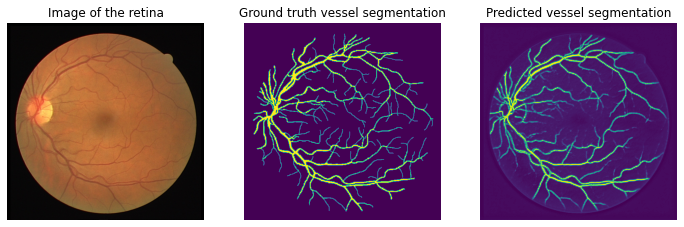

In [4]:
# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()